<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/bam098_plant_pathology_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Pathology

Kaggle Competition: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data

In [1]:
! pip uninstall fastai -y
! pip install fastai
! pip install iterative-stratification

Uninstalling fastai-2.1.8:
  Successfully uninstalled fastai-2.1.8
  Using cached https://files.pythonhosted.org/packages/ff/53/da994550c0dd2962351fd694694e553afe0c9516c02251586790f830430b/fastai-2.1.8-py3-none-any.whl


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import platform
import fastai
from fastai.vision.all import *
import sklearn
from sklearn.metrics import roc_auc_score
import iterstrat
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
import torchvision
import pandas as pd
from typing import Dict, List
from tqdm.notebook import tqdm

print('python version:      {}'.format(platform.python_version()))
print('fastai version:      {}'.format(fastai.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('iterstrat version:   {}'.format(iterstrat.__version__))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('pandas version:      {}'.format(pd.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
fastai version:      2.1.8
sklearn version:     0.22.2.post1
iterstrat version:   0.1.6
torch version:       1.7.0+cu101
torchvision version: 0.8.1+cu101
pandas version:      1.1.4
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
#torch.set_deterministic(True)

## Data

In [5]:
labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
data_dir = Path('/content/gdrive/MyDrive/fastai/data/plant-pathology')
img_dir  = data_dir / 'images'

In [6]:
data_dir.ls()

(#4) [Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/train.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/test.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/sample_submission.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images')]

In [7]:
img_dir.ls()

(#3642) [Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1702.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1712.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_171.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1710.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1738.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1736.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1771.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1770.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1765.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1756.jpg')...]

### Explore Data

In [8]:
test_df = pd.read_csv(data_dir/'test.csv')
train_df = pd.read_csv(data_dir/'train.csv'); train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


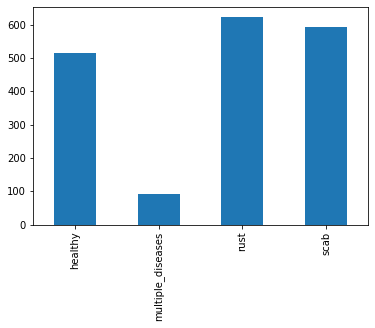

In [9]:
train_df[labels].sum().plot(kind='bar')

In [10]:
def get_size(df):
    hs, ws = [], []
    for _, row in tqdm(df.iterrows(), total=len(train_df)):
        img = Image.open(img_dir/(row.image_id+'.jpg'))
        h, w = img.size
        hs.append(h)
        ws.append(w)
        
    return hs, ws

In [11]:
train_hs, train_ws = get_size(train_df)
test_hs, test_ws = get_size(test_df)

train height val counts: Counter({2048: 1819, 1365: 2})
train width val counts: Counter({1365: 1819, 2048: 2})
test height val counts: Counter({2048: 1801, 1365: 20})
test width val counts: Counter({1365: 1801, 2048: 20})


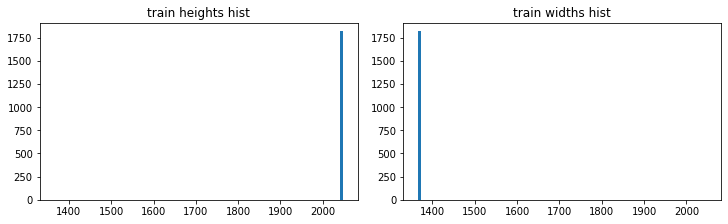

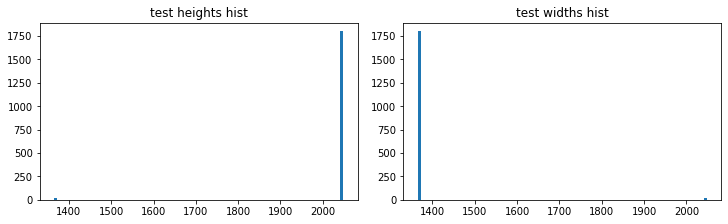

In [12]:
for set_label, set_size in ('train', [train_hs, train_ws]), ('test', [test_hs, test_ws]):
    print(f'{set_label} height val counts: {Counter(set_size[0])}')
    print(f'{set_label} width val counts: {Counter(set_size[1])}')

    _, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 3))
    for ax, column, vals in zip(axes, ['heights', 'widths'], set_size):
        ax.hist(vals, bins=100)
        ax.set_title(f'{set_label} {column} hist')

plt.show()

### Prepare Data

In [13]:
img_size = 600
bs = 16

In [14]:
train_df['label'] = train_df[labels].idxmax(1); train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [15]:
# reference: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

train_df['fold'] = -1

strat_kfold = MultilabelStratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.image_id.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

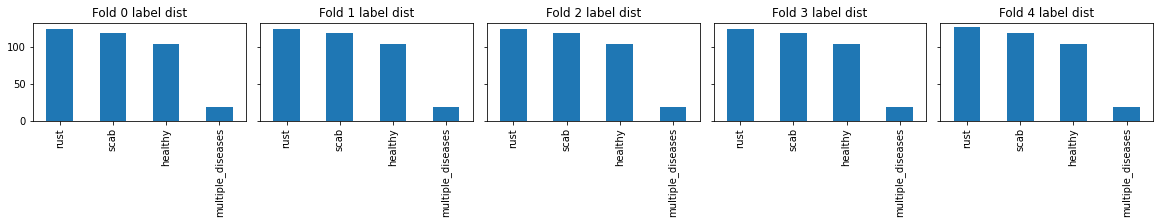

In [16]:
_, axes = plt.subplots(ncols=5, nrows=1, constrained_layout=True, figsize=(16, 3), sharey=True)
for ax, fold in zip(axes, range(5)):
    train_df.query(f'fold == {fold}')[labels].idxmax(axis=1).value_counts().plot.bar(ax=ax)
    ax.set_title(f'Fold {fold} label dist') 

plt.show()

In [17]:
# reference: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

def get_data(fold):
    train_df_no_val = train_df.query(f'fold != {fold}')
    train_df_just_val = train_df.query(f'fold == {fold}')

    train_df_bal = pd.concat(
        [train_df_no_val.query('label != "multiple_diseases"'), train_df_just_val] +
        [train_df_no_val.query('label == "multiple_diseases"')] * 2
    ).sample(frac=1.0, random_state=random_seed).reset_index(drop=True)

    datablock = DataBlock(
        blocks=(ImageBlock, CategoryBlock(vocab=labels)),
        getters=[
            ColReader('image_id', pref=img_dir, suff='.jpg'),
            ColReader('label')
        ],
        splitter=IndexSplitter(train_df_bal.loc[train_df_bal.fold==fold].index),
        item_tfms=Resize(img_size),
        batch_tfms=aug_transforms(size=img_size, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True)
    )
    return datablock.dataloaders(source=train_df_bal, bs=bs)

In [18]:
dls = get_data(fold=0)

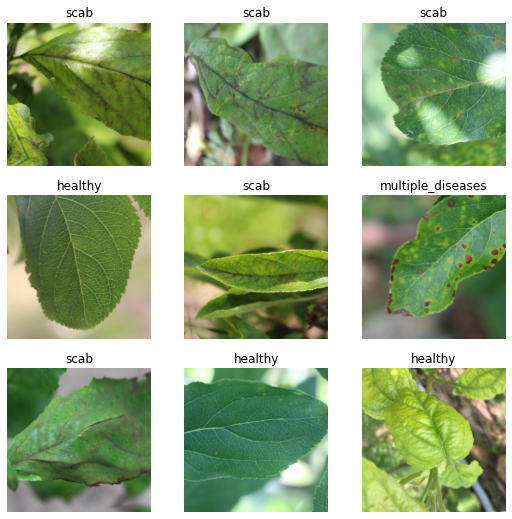

In [19]:
dls.show_batch()

## Metric

In [20]:
# reference: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

def comp_metric(preds, targs, labels=range(len(labels))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

## Training

In [21]:
arch = densenet201

In [22]:
def get_learner(fold_num, lr=1e-3):
    opt_func = partial(RAdam, lr=lr, wd=0.01, eps=1e-8)

    data = get_data(fold_num)

    learn = cnn_learner(
        data, arch, opt_func=opt_func,
        loss_func=LabelSmoothingCrossEntropy(),
        metrics=[
            AccumMetric(healthy_roc_auc, flatten=False),
            AccumMetric(multiple_diseases_roc_auc, flatten=False),
            AccumMetric(rust_roc_auc, flatten=False),
            AccumMetric(scab_roc_auc, flatten=False),
            AccumMetric(comp_metric, flatten=False)]
        ).to_fp16()

    return learn

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=9.12010818865383e-07)

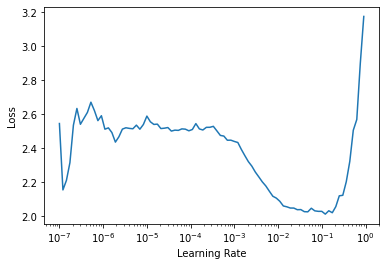

In [23]:
get_learner(fold_num=0).lr_find()

In [24]:
def print_metrics(val_preds, val_labels):
    comp_metric_fold = comp_metric(val_preds, val_labels)
    print(f'Comp metric: {comp_metric_fold}')
    
    healthy_roc_auc_metric = healthy_roc_auc(val_preds, val_labels)
    print(f'Healthy metric: {healthy_roc_auc_metric}')
    
    multiple_diseases_roc_auc_metric = multiple_diseases_roc_auc(val_preds, val_labels)
    print(f'Multi disease: {multiple_diseases_roc_auc_metric}')
    
    rust_roc_auc_metric = rust_roc_auc(val_preds, val_labels)
    print(f'Rust metric: {rust_roc_auc_metric}')
    
    scab_roc_auc_metric = scab_roc_auc(val_preds, val_labels)
    print(f'Scab metric: {scab_roc_auc_metric}')

In [25]:
lr = 3e-2

Fold 0 results


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,1.484749,3.365405,0.986720,0.542791,0.884677,0.952753,0.841735,02:13
1,1.370352,1.034513,0.948983,0.872832,0.989113,0.910238,0.930292,02:15
2,0.923471,0.521725,0.978537,0.936577,0.998656,0.993586,0.976839,02:16
3,0.702652,0.485104,0.993955,0.921805,0.999530,0.993998,0.977322,02:15


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,0.729417,1.277924,0.747368,0.675739,0.995699,0.989230,0.852009,02:36
1,0.858616,0.758213,0.874307,0.784361,0.974866,0.981650,0.903796,02:36
2,0.780620,1.249350,0.695532,0.803629,0.910333,0.983879,0.848343,02:35
3,0.729542,0.537946,0.995090,0.831647,0.998942,0.995507,0.955296,02:35
4,0.653464,0.487143,0.995945,0.878292,0.999731,0.995541,0.967377,02:37
5,0.626920,0.477142,0.997694,0.823298,0.999530,0.995164,0.953921,02:37
6,0.565785,0.448673,0.997006,0.920360,0.999731,0.995318,0.978104,02:37
7,0.550512,0.460628,0.996727,0.905106,0.999630,0.995232,0.974174,02:36


Comp metric: 0.9758820977353676
Healthy metric: 0.9969497451921289
Multi disease: 0.9113680154142582
Rust metric: 0.9993951612903226
Scab metric: 0.9958154690447608


Fold 1 results


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,1.438981,1.434360,0.929937,0.798812,0.982964,0.956234,0.916987,02:13
1,1.328313,0.805252,0.988320,0.748154,0.992372,0.938981,0.916957,02:16
2,0.926325,0.515835,0.992821,0.891779,0.998454,0.979369,0.965606,02:15
3,0.689661,0.495346,0.992672,0.933044,0.997144,0.984600,0.976865,02:15


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,0.733628,0.856655,0.945002,0.687781,0.987013,0.986623,0.901605,02:35
1,0.843501,1.889187,0.938288,0.632948,0.852974,0.981255,0.851366,02:35
2,0.847722,0.539997,0.993788,0.884714,0.995917,0.988304,0.965681,02:35
3,0.714755,0.592202,0.994085,0.757386,0.995531,0.991871,0.934718,02:35
4,0.669773,0.529592,0.985641,0.885678,0.998790,0.989624,0.964933,02:35
5,0.621032,0.487980,0.990589,0.932723,0.998303,0.994306,0.978980,02:35
6,0.587482,0.499770,0.989287,0.927103,0.998286,0.990293,0.976242,02:35
7,0.541828,0.471994,0.991184,0.921162,0.998454,0.994581,0.976345,02:35


Comp metric: 0.9762377898425527
Healthy metric: 0.9911096231819365
Multi disease: 0.9238921001926782
Rust metric: 0.9983870967741936
Scab metric: 0.9915623392214028


Fold 2 results


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,1.477956,9.834064,0.707175,0.649566,0.674042,0.436906,0.616922,02:12
1,1.244635,0.773970,0.953236,0.775771,0.950756,0.927208,0.901743,02:15
2,0.863142,0.649831,0.984375,0.788215,0.977167,0.969426,0.929796,02:15
3,0.695375,0.530021,0.987611,0.844091,0.991196,0.987633,0.952633,02:15


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,0.743320,0.916929,0.976664,0.779865,0.978595,0.985858,0.930246,02:35
1,0.847586,0.773914,0.980399,0.786288,0.978495,0.989975,0.933789,02:35
2,0.793729,0.646932,0.956731,0.856455,0.986240,0.990802,0.947557,02:35
3,0.704699,0.598805,0.982951,0.870906,0.983501,0.987099,0.956114,02:34
4,0.627603,0.578668,0.990422,0.892180,0.989953,0.994436,0.966748,02:35
5,0.600257,0.516505,0.994286,0.905427,0.986862,0.996176,0.970688,02:35
6,0.584416,0.491207,0.994933,0.924695,0.985568,0.993971,0.974792,02:35
7,0.555277,0.491777,0.994822,0.920520,0.986206,0.996486,0.974509,02:35


Comp metric: 0.9746066930321375
Healthy metric: 0.9950073964497042
Multi disease: 0.9216441875401412
Rust metric: 0.985013440860215
Scab metric: 0.9967617472784898


Fold 3 results


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,1.444161,1.134712,0.950154,0.682075,0.994523,0.972234,0.899746,02:13
1,1.208036,0.850159,0.997340,0.766438,0.879923,0.994212,0.909478,02:15
2,0.906612,0.529897,0.992505,0.820061,0.997026,0.994523,0.951029,02:16
3,0.701126,0.471995,0.989808,0.967963,0.999059,0.998794,0.988906,02:16


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,0.716207,1.265415,0.917457,0.776735,0.977453,0.969461,0.910276,02:37
1,0.871874,1.092074,0.959454,0.775515,0.841095,0.995143,0.892802,02:38
2,0.765256,0.527416,0.989919,0.968421,0.998152,0.987495,0.985997,02:39
3,0.726804,0.587877,0.989808,0.906484,0.998253,0.997726,0.973068,02:39
4,0.662980,0.568856,0.995201,0.923417,0.999026,0.991663,0.977327,02:40
5,0.619199,0.481758,0.993007,0.944928,0.997816,0.998346,0.983524,02:40
6,0.570032,0.439857,0.995927,0.974371,0.998992,0.999208,0.992124,02:41
7,0.533850,0.457693,0.993230,0.973303,0.999126,0.999035,0.991174,02:41


Comp metric: 0.9950291317854989
Healthy metric: 0.9970241416508574
Multi disease: 0.9848970251716247
Rust metric: 0.9991599462365591
Scab metric: 0.9990354140829544


Fold 4 results


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,1.450424,1.286833,0.853072,0.507125,0.974729,0.966531,0.825364,02:16
1,1.302922,1.137766,0.989217,0.696286,0.977735,0.936149,0.899846,02:18
2,0.954277,0.563291,0.997832,0.893532,0.985571,0.997152,0.968522,02:17
3,0.680572,0.494230,0.997832,0.931796,0.993325,0.997221,0.980044,02:18


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,0.770644,1.879556,0.965945,0.401217,0.923939,0.966942,0.814511,02:39
1,0.909777,1.308320,0.674646,0.479267,0.979113,0.681380,0.703601,02:38
2,0.820478,0.541834,0.994182,0.810279,0.991914,0.995402,0.947944,02:39
3,0.700112,0.600690,0.998555,0.830291,0.985223,0.995540,0.952402,02:41
4,0.660456,0.490735,0.999240,0.905059,0.993624,0.997838,0.973941,02:40
5,0.604978,0.483697,0.998851,0.940762,0.991897,0.998816,0.982582,02:40
6,0.554567,0.484308,0.998888,0.933397,0.993724,0.998044,0.981013,02:40
7,0.543570,0.473633,0.998962,0.933237,0.994122,0.998216,0.981134,02:40


Comp metric: 0.9818956260097655
Healthy metric: 0.9988883124583117
Multi disease: 0.93611911623439
Rust metric: 0.9942219565650529
Scab metric: 0.998353118781308


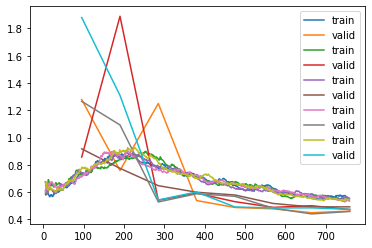

In [26]:
all_val_preds = []
all_val_labels = []
all_test_preds = []

for i in range(5):
    print(f'Fold {i} results')

    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(4, lr)
    learn.unfreeze()

    learn.fit_one_cycle(8, slice(3e-4, lr))
    
    learn.recorder.plot_loss()
    
    learn.save(f'model_fold_{i}')
    
    val_preds, val_labels = learn.get_preds()
    
    print_metrics(val_preds, val_labels)
    
    all_val_preds.append(val_preds)
    all_val_labels.append(val_labels)
    
    test_dl = dls.test_dl(test_df)
    test_preds, _ = learn.get_preds(dl=test_dl)
    all_test_preds.append(test_preds)
    
plt.show()

In [27]:
print_metrics(np.concatenate(all_val_preds), np.concatenate(all_val_labels))

Comp metric: 0.9793613709087878
Healthy metric: 0.995426059580029
Multi disease: 0.9308835672997523
Rust metric: 0.9951272362552931
Scab metric: 0.9960086205000771


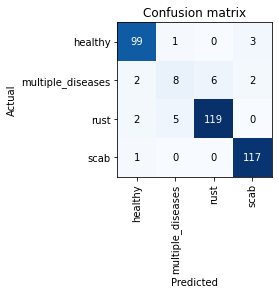

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

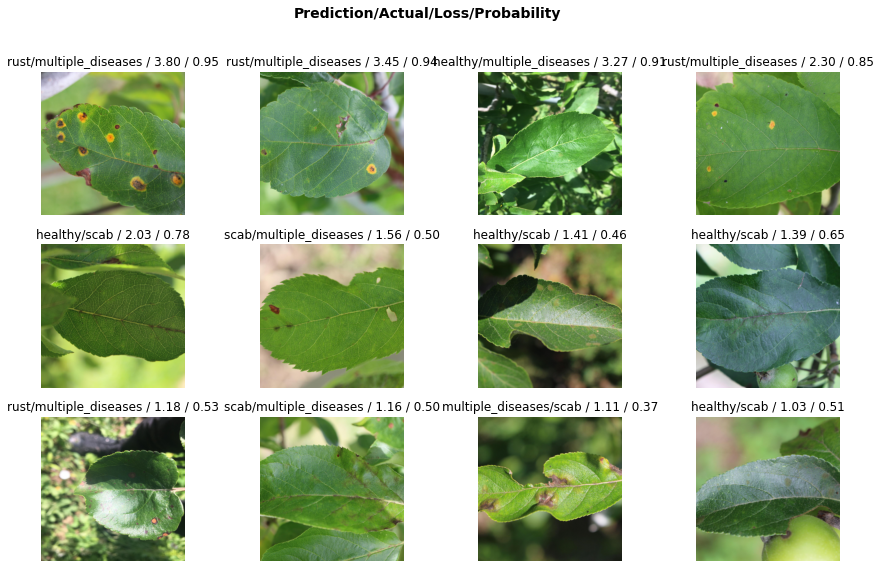

In [ ]:
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

## Submission

In [30]:
test_df_output = pd.concat([test_df, pd.DataFrame(np.mean(np.stack(all_test_preds), axis=0), columns=labels)], axis=1)

In [31]:
test_df_output.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.334419,0.066843,0.527527,0.071211
1,Test_1,0.431661,0.094382,0.339094,0.134863
2,Test_2,0.729458,0.025625,0.067063,0.177854
3,Test_3,0.936247,0.006718,0.030057,0.026978
4,Test_4,0.231796,0.068577,0.481189,0.218438


In [32]:
test_df_output.to_csv('submission.csv', index=False)

In [33]:
! head -n 5 submission.csv

image_id,healthy,multiple_diseases,rust,scab
Test_0,0.3344194,0.06684257,0.5275266,0.07121141
Test_1,0.4316605,0.09438249,0.33909422,0.13486281
Test_2,0.72945845,0.025625248,0.06706284,0.17785358
Test_3,0.93624717,0.0067183212,0.030056512,0.026977956


In [34]:
! pip uninstall -y kaggle
! pip install kaggle

Uninstalling kaggle-1.5.9:
  Successfully uninstalled kaggle-1.5.9
     |████████████████████████████████| 61kB 7.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=9c4ed288f341f20ec8f16b5a2c8b9aa88cfc7a61c3ab431d640c11214ecaa91d
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle


In [35]:
! cp -r /content/gdrive/My\ Drive/.kaggle/ /root/

In [36]:
! kaggle -v

Kaggle API 1.5.10


In [37]:
! kaggle competitions submit plant-pathology-2020-fgvc7 -f submission.csv -m "v4"

100% 95.6k/95.6k [00:00<00:00, 175kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7